# Pre-process 2D spectrum images

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
__main__ = 'EasyReduce'
__author__ = 'Pascal Louis <plouis35@gmail.com>'
__version__ = '1.2'
__keywords__ = ['astronomy', 'astropy', 'astroalign', 'ccdproc', 'matplotlib']


## import libraries

In [3]:
import matplotlib.pyplot as plt

%config InlineBackend.rc = {}
plt.style.use(['dark_background'])
plt.rcParams.update({'figure.max_open_warning': 0}) 
plt.rcParams['figure.constrained_layout.use'] = True
plt.close('all')

### set the mpl backend
%matplotlib widget
#%matplotlib inline

import sys
import logging

import warnings, fnmatch, os
from time import gmtime, strftime
from pathlib import Path

import numpy as np
from astropy import units as u
from astropy.nddata import CCDData
from ccdproc import ImageFileCollection, cosmicray_median, cosmicray_lacosmic, gain_correct
from convenience_functions import show_image
from easycombiner import Images

from astropy.utils.exceptions import AstropyWarning, AstropyUserWarning
warnings.simplefilter('ignore', category=AstropyWarning)
warnings.simplefilter('ignore', category=AstropyUserWarning)
warnings.simplefilter('ignore', UserWarning)



## define targets
```
TARGET = name of object, used for naming generated files
CAPTURE_DIR = directory with ending /
BIAS_FILES = wildcard bias files names (wild cards)
DARK_FILES = wildcard dark files names (wild cards)
FLAT_FILES = wildcard flat files names (wild cards)
CALIB_FILES = wildcard neon files names (wild cards)
SCIENCE_FILES = wildcard science files names (wild cards)
Y_CROP = relative y center, relative crop arround this y center
EXPOSURE_KEY = fit keyword defining 'EXPOSURE'
CAMERA_ELECTRONIC_GAIN = # asi 183mm : 0.13 * u.electron/u.adu   # atik 420m : 0.024 asi183mm
CAMERA_READOUT_NOISE = # asi 183mm : 3.0 * u.electron     # atik 420m : 2.8 asi183mm


In [4]:
TARGET = 'markab'
CAPTURE_DIR='../../../CAPTURES/20161200_CHATEAU_TIPE/spectro_TIPE_bruts/'
BIAS_FILES = "offset_DD200-0*.fit"
DARK_FILES = "dark10m_DD200-0*.fit"
FLAT_FILES = "flat-0*.fit"
CALIB_FILES = "calib-00*.fit"
SCIENCE_FILES = "markab-00*.fit"
#Y_CROP = "0.4, 0.3"
Y_CROP = None
EXPOSURE_KEY = 'EXPTIME'
CAMERA_ELECTRONIC_GAIN = 0.13 * u.electron/u.adu   
CAMERA_READOUT_NOISE = 3.0 * u.electron     


## define logger

In [5]:
### logger prints after every notebook cell
logging.basicConfig(
    format='%(asctime)s [%(levelname)s] - %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    stream=sys.stdout,
)
logger = logging.getLogger('notebook')


## create masterbias

2025-02-22 19:45:24 [INFO] - image : ../../../CAPTURES/20161200_CHATEAU_TIPE/spectro_TIPE_bruts/offset_DD200-001.fit loaded
2025-02-22 19:45:24 [INFO] - image : ../../../CAPTURES/20161200_CHATEAU_TIPE/spectro_TIPE_bruts/offset_DD200-002.fit loaded
2025-02-22 19:45:24 [INFO] - image : ../../../CAPTURES/20161200_CHATEAU_TIPE/spectro_TIPE_bruts/offset_DD200-003.fit loaded
2025-02-22 19:45:24 [INFO] - image : ../../../CAPTURES/20161200_CHATEAU_TIPE/spectro_TIPE_bruts/offset_DD200-004.fit loaded
2025-02-22 19:45:24 [INFO] - image : ../../../CAPTURES/20161200_CHATEAU_TIPE/spectro_TIPE_bruts/offset_DD200-005.fit loaded
2025-02-22 19:45:24 [INFO] - image : ../../../CAPTURES/20161200_CHATEAU_TIPE/spectro_TIPE_bruts/offset_DD200-006.fit loaded
2025-02-22 19:45:24 [INFO] - image : ../../../CAPTURES/20161200_CHATEAU_TIPE/spectro_TIPE_bruts/offset_DD200-007.fit loaded
2025-02-22 19:45:24 [INFO] - image : ../../../CAPTURES/20161200_CHATEAU_TIPE/spectro_TIPE_bruts/offset_DD200-008.fit loaded
2025-02-

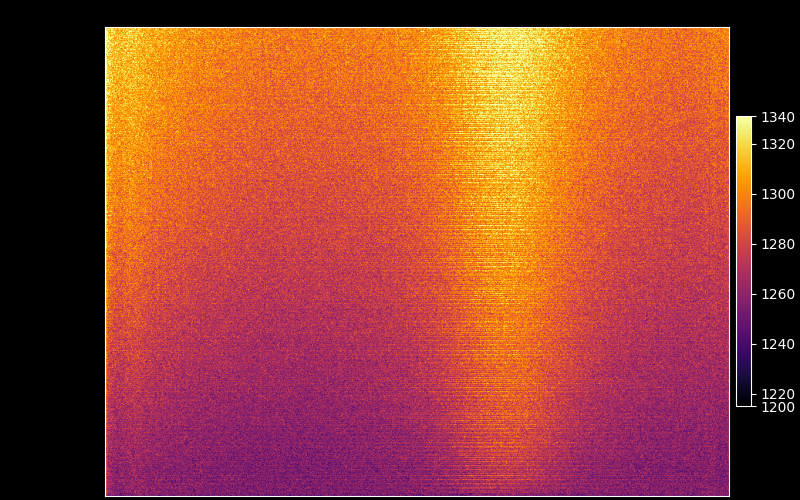

In [6]:
### create master bias
if (BIAS_FILES is not None): # and not (os.path.exists(CAPTURE_DIR + 'masterbias.fit')):
    master_bias = Images.from_fit(dir = CAPTURE_DIR, filter = BIAS_FILES, 
                                  camera_electronic_gain = CAMERA_ELECTRONIC_GAIN, camera_readout_noise = CAMERA_READOUT_NOISE) \
                        .y_crop(Y_CROP) \
                        .median() 
                        #.sigmaclip() 
                        #.offset(1500 * u.adu) \
    
    master_bias.uncertainty = None
    master_bias.flags = None
    #master_bias.data = master_bias.data.astype('float32')

    master_bias.write(CAPTURE_DIR + 'masterbias.fit', overwrite=True) 
    logger.info(f'min={master_bias.min()}, max={master_bias.max()}, avg={master_bias.mean()}')
    show_image(image = master_bias, cmap='inferno', percl=0, percu=99) #, figsize=(50, ),) #, percl = 0, percu = 95)


## create masterdark

2025-02-22 19:45:26 [INFO] - image : ../../../CAPTURES/20161200_CHATEAU_TIPE/spectro_TIPE_bruts/dark10m_DD200-001.fit loaded
2025-02-22 19:45:26 [INFO] - image : ../../../CAPTURES/20161200_CHATEAU_TIPE/spectro_TIPE_bruts/dark10m_DD200-002.fit loaded
2025-02-22 19:45:26 [INFO] - image : ../../../CAPTURES/20161200_CHATEAU_TIPE/spectro_TIPE_bruts/dark10m_DD200-003.fit loaded
2025-02-22 19:45:26 [INFO] - image : ../../../CAPTURES/20161200_CHATEAU_TIPE/spectro_TIPE_bruts/dark10m_DD200-004.fit loaded
2025-02-22 19:45:26 [INFO] - image : ../../../CAPTURES/20161200_CHATEAU_TIPE/spectro_TIPE_bruts/dark10m_DD200-005.fit loaded
2025-02-22 19:45:26 [INFO] - image : ../../../CAPTURES/20161200_CHATEAU_TIPE/spectro_TIPE_bruts/dark10m_DD200-006.fit loaded
2025-02-22 19:45:26 [INFO] - image : ../../../CAPTURES/20161200_CHATEAU_TIPE/spectro_TIPE_bruts/dark10m_DD200-007.fit loaded
2025-02-22 19:45:27 [INFO] - image : ../../../CAPTURES/20161200_CHATEAU_TIPE/spectro_TIPE_bruts/dark10m_DD200-008.fit loaded


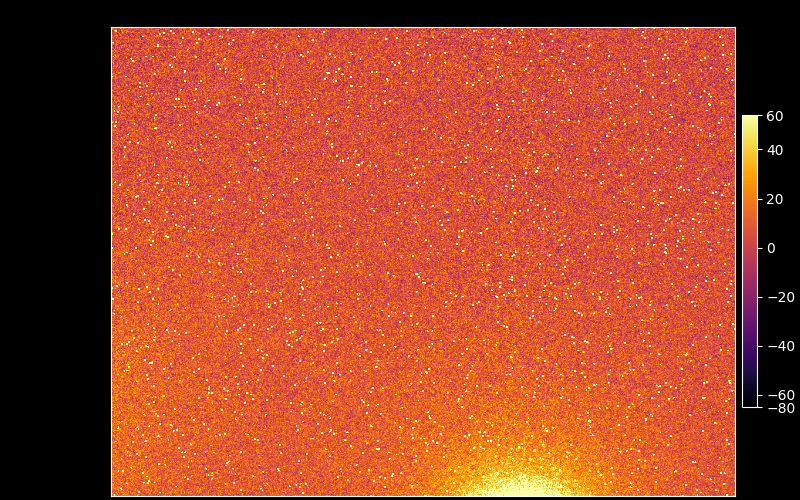

In [7]:
### create master dark
if (DARK_FILES is not None): # and not (os.path.exists(CAPTURE_DIR + 'masterdark.fit')):
    master_dark = Images.from_fit(dir = CAPTURE_DIR, filter = DARK_FILES, 
                                  camera_electronic_gain = CAMERA_ELECTRONIC_GAIN, camera_readout_noise = CAMERA_READOUT_NOISE) \
                        .y_crop(Y_CROP) \
                        .bias_substract(master_bias) \
                        .median() 
                        #.sigmaclip() 
                        #.offset(1500 * u.adu) \
    master_dark.uncertainty = None
    master_dark.flags = None
#    master_dark.data = master_dark.data.astype('int16')

    master_dark.write(CAPTURE_DIR + 'masterdark.fit', overwrite=True) 
    logger.info(f'min={master_dark.min()}, max={master_dark.max()}, avg={master_dark.mean()}')
    show_image(image = master_dark, cmap='inferno', percl=0, percu=99) #,  figsize=(50, ))


## create masterflat

2025-02-22 19:45:28 [INFO] - image : ../../../CAPTURES/20161200_CHATEAU_TIPE/spectro_TIPE_bruts/flat-001.fit loaded
2025-02-22 19:45:28 [INFO] - image : ../../../CAPTURES/20161200_CHATEAU_TIPE/spectro_TIPE_bruts/flat-002.fit loaded
2025-02-22 19:45:29 [INFO] - image : ../../../CAPTURES/20161200_CHATEAU_TIPE/spectro_TIPE_bruts/flat-003.fit loaded
2025-02-22 19:45:29 [INFO] - image : ../../../CAPTURES/20161200_CHATEAU_TIPE/spectro_TIPE_bruts/flat-004.fit loaded
2025-02-22 19:45:29 [INFO] - image : ../../../CAPTURES/20161200_CHATEAU_TIPE/spectro_TIPE_bruts/flat-005.fit loaded
2025-02-22 19:45:29 [INFO] - image : ../../../CAPTURES/20161200_CHATEAU_TIPE/spectro_TIPE_bruts/flat-006.fit loaded
2025-02-22 19:45:29 [INFO] - image : ../../../CAPTURES/20161200_CHATEAU_TIPE/spectro_TIPE_bruts/flat-007.fit loaded
2025-02-22 19:45:29 [INFO] - image : ../../../CAPTURES/20161200_CHATEAU_TIPE/spectro_TIPE_bruts/flat-008.fit loaded
2025-02-22 19:45:29 [INFO] - image : ../../../CAPTURES/20161200_CHATEAU_

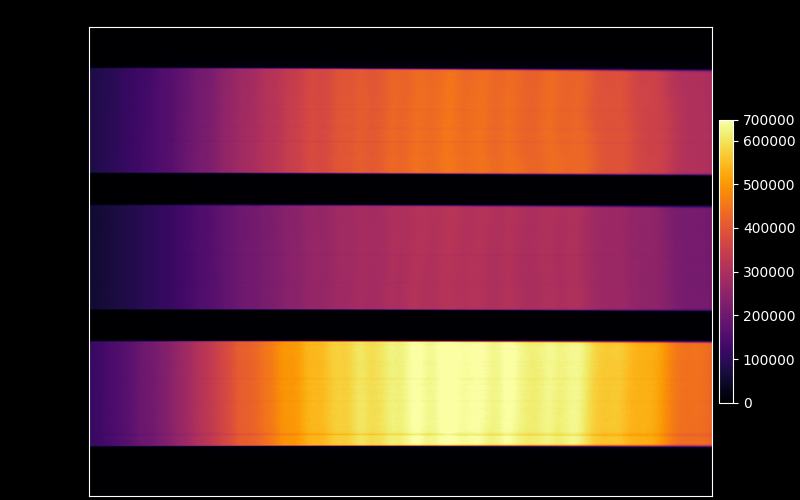

In [8]:
### create master flat
if (FLAT_FILES is not None): # and not (os.path.exists(CAPTURE_DIR + 'masterflat.fit')):
    master_flat = Images.from_fit(dir = CAPTURE_DIR, filter = FLAT_FILES, 
                                  camera_electronic_gain = CAMERA_ELECTRONIC_GAIN, camera_readout_noise = CAMERA_READOUT_NOISE) \
                        .y_crop(Y_CROP) \
                        .bias_substract(master_bias) \
                        .sum()
#                        .median()
#                        .offset(1500 * u.adu) \

    master_flat.uncertainty = None
    master_flat.flags = None
#    master_flat.data = master_flat.data.astype('int16')

    master_flat.write(CAPTURE_DIR + 'masterflat.fit', overwrite=True) 
    logger.info(f'min={master_flat.min()}, max={master_flat.max()}, avg={master_flat.mean()}')
    show_image(image = master_flat, cmap='inferno', percl=0, percu=99) #,  figsize=(50, ))


## create mastercalib

2025-02-22 19:45:30 [INFO] - image : ../../../CAPTURES/20161200_CHATEAU_TIPE/spectro_TIPE_bruts/calib-001.fit loaded
2025-02-22 19:45:30 [INFO] - image : ../../../CAPTURES/20161200_CHATEAU_TIPE/spectro_TIPE_bruts/calib-002.fit loaded
2025-02-22 19:45:30 [INFO] - image : ../../../CAPTURES/20161200_CHATEAU_TIPE/spectro_TIPE_bruts/calib-003.fit loaded
2025-02-22 19:45:30 [INFO] - no y-cropping to do
2025-02-22 19:45:30 [INFO] - masterbias substracted to 3 images
2025-02-22 19:45:30 [INFO] - median combine on 3 images ...
2025-02-22 19:45:30 [INFO] - min=-102.0 adu, max=16188.0 adu, avg=473.46173 adu


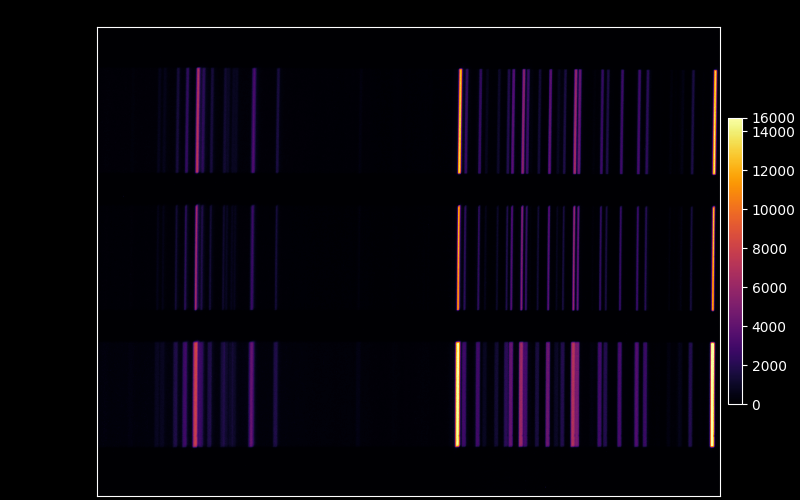

In [9]:
### create master calib
if (CALIB_FILES is not None): # and not (os.path.exists(CAPTURE_DIR + 'mastercalib.fit')):
    master_calib = Images.from_fit(dir = CAPTURE_DIR, filter = CALIB_FILES,
                                   camera_electronic_gain = CAMERA_ELECTRONIC_GAIN, camera_readout_noise = CAMERA_READOUT_NOISE) \
                         .y_crop(Y_CROP) \
                         .bias_substract(master_bias) \
                         .median()
                         #.sigmaclip()
#                         .offset(1500 * u.adu) \

    master_calib.uncertainty = None
    master_calib.flags = None
#    master_calib.data = master_calib.data.astype('int16')

    master_calib.write(CAPTURE_DIR + 'mastercalib.fit', overwrite=True) 
    logger.info(f'min={master_calib.min()}, max={master_calib.max()}, avg={master_calib.mean()}')
    show_image(image = master_calib, cmap='inferno', percl=10, percu=99.9) # ,figsize=(50, ))


## reduce science frames

2025-02-22 19:45:30 [INFO] - read refernce frames...
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2025-02-22 19:45:30 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2025-02-22 19:45:30 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2025-02-22 19:45:30 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
2025-02-22 19:45:30 [INFO] - image : ../../../CAPTURES/20161200_CHATEAU_TIPE/spectro_TIPE_bruts/markab-001.fit loaded
2025-02-22 19:45:30 [INFO] - image : ../../../CAPTURES/20161200_CHATEAU_TIPE/spectro_TIPE_bruts/markab-002.fit loaded
2025-02-2

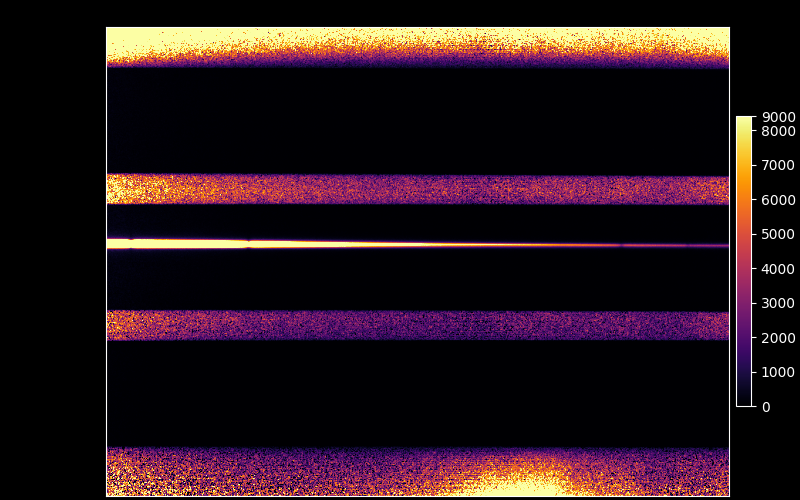

In [10]:
### read master reference frames
logger.info('read refernce frames...')

master_bias = CCDData.read(CAPTURE_DIR + 'masterbias.fit', unit = u.adu)
master_dark = CCDData.read(CAPTURE_DIR + 'masterdark.fit', unit = u.adu)
master_flat = CCDData.read(CAPTURE_DIR + 'masterflat.fit', unit = u.adu)

### reduce science frames
master_sciences = Images.from_fit(dir = CAPTURE_DIR, filter = SCIENCE_FILES, 
                                  camera_electronic_gain = CAMERA_ELECTRONIC_GAIN, camera_readout_noise = CAMERA_READOUT_NOISE) \
                        .y_crop(Y_CROP) \
                        .reduce(master_bias = master_bias, master_dark = master_dark, master_flat = master_flat, exposure_key = EXPOSURE_KEY) \
                        .spec_align(ref_image_index = 0)                        # fft based - best for spectra fields

### optional: save individual frames
for i, frame in zip(range(0, len(master_sciences)), master_sciences):
    frame.uncertainty = None
    frame.flags = None
#    frame.data = frame.data.astype('int16')

    frame.write(f'{CAPTURE_DIR}{TARGET}-{i}-reduced.fit', overwrite=True)
    logger.info(f'frame {i}: min={frame.min()}, max={frame.max()}, avg={frame.mean()}')

### combine frames (sum or median) & save master science frame
#master_science = master_sciences.sum() 
master_science = master_sciences.median()

### update fits header
master_science.meta['EXPTIME2'] = f'{len(master_sciences)} x {master_science.meta[EXPOSURE_KEY]} s'
master_science.meta['EXPTIME'] = len(master_sciences) * master_science.meta[EXPOSURE_KEY]

master_science.uncertainty = None
master_science.flags = None
#master_science.data = master_science.data.astype('int16')

master_science.write(f'{CAPTURE_DIR}{TARGET}-reduced.fit', overwrite=True)
logger.info(f'master_science: min={master_science.min()}, max={master_science.max()}, avg={master_science.mean()}')
show_image(image = master_science, cmap='inferno', percl=10, percu=95)


## remove cosmics (optional)

2025-02-22 19:45:32 [INFO] - master_science: min=-21088.133 adu, max=102519.92 adu, avg=1620.5999 adu
2025-02-22 19:45:32 [INFO] - gain_corrected: min=-2741.457265625 electron, max=13327.58984375 electron, avg=210.67798104573956 electron
Starting 4 L.A.Cosmic iterations
Iteration 1:
51556 cosmic pixels this iteration
Iteration 2:
58774 cosmic pixels this iteration
Iteration 3:
50141 cosmic pixels this iteration
Iteration 4:
25949 cosmic pixels this iteration
2025-02-22 19:45:32 [INFO] - master_science_clean: min=-2741.4573 electron, max=13327.59 electron, avg=51.47741 electron


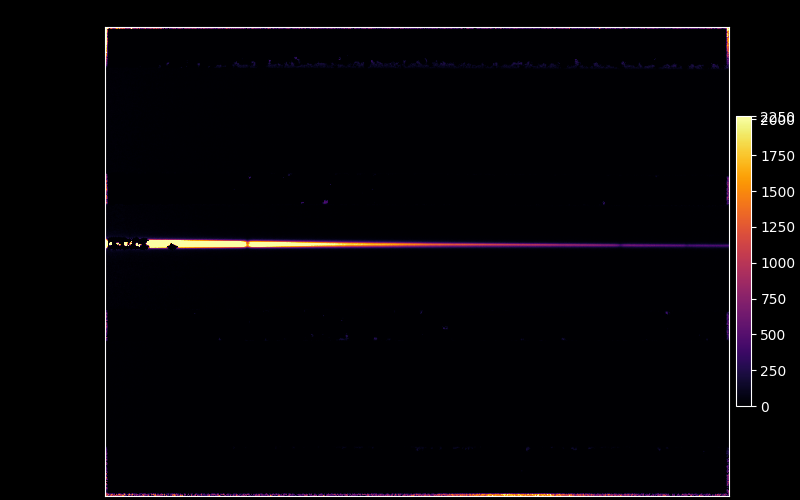

In [11]:
from astropy.convolution import convolve, Gaussian2DKernel, Tophat2DKernel
from astropy.modeling.models import Gaussian2D
from astropy.convolution import Box2DKernel

logger.info(f'master_science: min={master_science.min()}, max={master_science.max()}, avg={master_science.mean()}')

gain_corrected = gain_correct(master_science, CAMERA_ELECTRONIC_GAIN)
logger.info(f'gain_corrected: min={gain_corrected.min()}, max={gain_corrected.max()}, avg={gain_corrected.mean()}')


master_science_clean = cosmicray_lacosmic(gain_corrected,
                                          #satlevel = 10,
                                          #niter = 1,
                                          gain_apply = False,
                                          sigclip = 7,
                                          cleantype = 'median',
                                          fsmode = 'median',
                                          verbose = True
                                         )
"""
#cosmicray_median(sci_master, thresh = 3, mbox=3, rbox=5, gbox=3, error_image = np.ones(sci_master.shape))
#sci_cleaned = cosmicray_median(sci_master, thresh = 3, mbox=3, rbox=5, gbox=3, error_image = np.ones(sci_master.shape))
master_science_clean = cosmicray_median(gain_corrected, #gain_corrected,
                                        thresh = 3,
                                        mbox = 3,
                                        rbox = 5, 
                                        gbox = 3,
                                        #error_image = np.ones(gain_corrected.shape)
                                       )

"""
#tophat_kernel = Box2DKernel(5)
#master_science_clean = convolve(gain_corrected, tophat_kernel)

#master_science_clean = CCDData(CCDData.add(master_science_clean, 1000 * u.electron))
                                
#print(master_science_clean.unit)
logger.info(f'master_science_clean: min={master_science_clean.min()}, max={master_science_clean.max()}, avg={master_science_clean.mean()}')

master_science_clean.uncertainty = None
master_science_clean.flags = None
#master_science_clean.data = master_science_clean.data.astype('int16')

master_science_clean.write(f'{CAPTURE_DIR}{TARGET}-reduced-cosmics.fit', overwrite=True)
show_image(image = master_science_clean, cmap='inferno', percl=15, percu=99.5)


In [12]:
import numpy as np
#logger.info(f'master_science avg uncertainty : {master_science.uncertainty.array.mean()}')
#logger.info(f'master_science clean avg uncertainty : {master_science_clean.uncertainty.array.mean()}')
